In [2]:
from __future__ import print_function

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

Automatically created module for IPython interactive environment


In [17]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((8, 8)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling
X[X>0.5] = 1.0
X[X<=0.5] = 0.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

(64,)


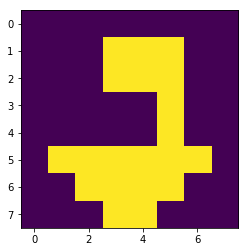

In [18]:
from matplotlib import pyplot as plt
print( X_train[0].shape)
plt.imshow(X_train[0].reshape(8,8))
plt.show()

In [23]:
# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 10
logistic.C = 6000.0

# Training RBM-Logistic Pipeline
classifier.fit(X_train, Y_train)


[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.64, time = 0.11s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.36, time = 0.09s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -23.13, time = 0.08s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -22.66, time = 0.07s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -22.45, time = 0.08s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -22.00, time = 0.07s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -21.87, time = 0.07s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -21.65, time = 0.08s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -21.55, time = 0.07s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -21.51, time = 0.08s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -21.46, time = 0.08s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -21.34, time = 0.08s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -21.79, time = 0.11s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -21.25, time = 0.10s
[BernoulliRBM] Iteration 15, 

Pipeline(steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.06, n_components=10, n_iter=20,
       random_state=0, verbose=True)), ('logistic', LogisticRegression(C=6000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [24]:
print()
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        Y_train,
        classifier.predict(X_train))))


Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.53      0.53      0.53       716
          1       0.47      0.38      0.42       726
          2       0.49      0.52      0.50       719
          3       0.40      0.33      0.36       721
          4       0.58      0.64      0.61       719
          5       0.35      0.48      0.41       729
          6       0.60      0.73      0.66       698
          7       0.47      0.70      0.56       741
          8       0.51      0.08      0.14       688
          9       0.42      0.39      0.40       731

avg / total       0.48      0.48      0.46      7188




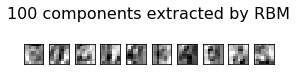

In [25]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()